<a href="https://colab.research.google.com/github/Supersamk13/Machine-Learning-and-Data-Science/blob/main/Data_Science_and_Machine_Learning_Project_Interstate_Traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Hello, my name is Samuel Kinstlinger. Over the past couple years I have been working on growing my skillset is the fields of data science and machine learing. This is a project I completed early on in my endeavor to practice data cleaning, data preprocessing, data visualization, and implementing regression models. I will be using a data set from Kaggle that gives information on the weather, date and time, and traffic volume.

### Goals
* Answer important questions about interstate traffic and the underlying related factors
* Implement and tune machine learning models to best predict interstate traffic volume

### Outline
* Getting to Know the Data
* EDA
* Data Visualization
* Data Cleaning and Preprocessing
* Machine Learning
* Conclusion

In [1592]:
# Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [1593]:
# Set up data frame
url='https://github.com/Supersamk13/Machine-Learning-and-Data-Science/raw/main/Metro_Interstate_Traffic_Volume%5B1%5D.csv'
traffic_df=pd.read_csv(url)

# Getting to Know the Data
* Understanding feature data types and information

In [1594]:
# Getting to Know the Data
print(traffic_df.head())
print(traffic_df.tail())

  holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0    None  288.28      0.0      0.0          40       Clouds   
1    None  289.36      0.0      0.0          75       Clouds   
2    None  289.58      0.0      0.0          90       Clouds   
3    None  290.13      0.0      0.0          90       Clouds   
4    None  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918  
      holiday    temp  rain_1h  snow_1h  clouds_all  weather_main  \
48199    None  283.45      0.0      0.0          75        Clouds   
48200    None  282.76      0.0      0.0          90        Clouds   
48201    None  282.73      0.0      0.0   

In [1595]:
print(traffic_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB
None


* All data is non-null; no need to fill or remove missing values
* If there were missing data, I would either remove it if it was negligible or do some KNN imputation to fill it in otherwise (or a superior model)

In [1596]:
for index in range(traffic_df.shape[1]):
  print(traffic_df.columns[index])
  print(traffic_df.iloc[:,index].unique())

holiday
['None' 'Columbus Day' 'Veterans Day' 'Thanksgiving Day' 'Christmas Day'
 'New Years Day' 'Washingtons Birthday' 'Memorial Day' 'Independence Day'
 'State Fair' 'Labor Day' 'Martin Luther King Jr Day']
temp
[288.28 289.36 289.58 ... 306.08 304.41 304.9 ]
rain_1h
[0.0000e+00 2.5000e-01 5.7000e-01 3.8000e-01 3.0000e-01 2.9000e-01
 4.4000e-01 3.6000e-01 2.1600e+00 3.3900e+00 8.4000e-01 7.6000e-01
 5.1000e-01 6.9000e-01 1.0000e+00 1.2900e+00 1.3400e+00 1.8400e+00
 1.7000e+00 4.7000e-01 1.4100e+00 1.4400e+00 7.0000e-01 3.1800e+00
 6.1000e-01 6.4000e-01 1.0200e+00 5.4200e+00 8.6400e+00 5.7400e+00
 4.9800e+00 3.6500e+00 6.8000e-01 4.6000e-01 4.2000e-01 1.5200e+00
 8.9000e-01 1.4000e+00 1.2190e+01 2.2900e+00 7.5400e+00 6.9400e+00
 1.6380e+01 1.7800e+00 2.5400e+00 9.1400e+00 3.0500e+00 1.6500e+00
 4.4450e+01 3.8100e+00 5.8400e+00 3.5600e+00 7.3700e+00 1.3500e+00
 1.6000e+01 1.0540e+01 1.2700e+00 5.0800e+00 1.9900e+01 2.5320e+01
 2.1420e+01 5.5900e+00 7.1100e+00 5.9700e+00 9.5300e+00 2.0

In [1597]:
# Stats about each numeric feature
print(traffic_df.describe())

               temp       rain_1h       snow_1h    clouds_all  traffic_volume
count  48204.000000  48204.000000  48204.000000  48204.000000    48204.000000
mean     281.205870      0.334264      0.000222     49.362231     3259.818355
std       13.338232     44.789133      0.008168     39.015750     1986.860670
min        0.000000      0.000000      0.000000      0.000000        0.000000
25%      272.160000      0.000000      0.000000      1.000000     1193.000000
50%      282.450000      0.000000      0.000000     64.000000     3380.000000
75%      291.806000      0.000000      0.000000     90.000000     4933.000000
max      310.070000   9831.300000      0.510000    100.000000     7280.000000


In [1598]:
# Stats about each categorical feature
print(traffic_df.describe(include='object'))

       holiday weather_main weather_description            date_time
count    48204        48204               48204                48204
unique      12           11                  38                40575
top       None       Clouds        sky is clear  2013-05-19 10:00:00
freq     48143        15164               11665                    6


* holiday is very imbalanced towards no holiday
* holiday and weather_main have a small amount of categories making One-Hot Encoding a viable option for some models (maybe also weather_description)
* For date_time, second is most likely unimportant; note to compare model performance including second vs. excluding second
* Above comment may also be applicable for minute
* date_time may be tricky for parametric models as it requires nuance for analysis


### Feature Conclusions
* holiday- Categorical, US National holidays plus regional holidays
* temp- Numeric, Average temp in kelvin
* rain_1h- Numeric, Amount in mm of rain that occurred in the hour
* snow_1h- Numeric, Amount in mm of snow that occurred in the hour
* clouds_all- Numeric, Percentage of cloud cover
* weather_main- Categorical, Short textual description of the current weather
* weather_description- Categorical, Longer textual description of the current weather
* date_time- DateTime, Hour of the data collected in local CST time
* traffic_volume- Numeric Hourly I-94 ATR 301 reported westbound traffic volume



### Other Data Info
* Shape = (48204, 9)
* Traffic is westbound
* Traffic is between Saint Paul and Minneapolis
* Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume. Collected from 2012-2018.

# EDA
* What are the best weather indicators of heavy traffic?
* During which time of day is traffic the heaviest (hours and day vs. night)?
* During which time of the year if traffic the heaviest (months and winter vs. summer)?
* Which holidays lead to the most traffic?
* How has traffic volume changed over the years?
* Which day(s) of the week have the most and least traffic?

# Data Visualization and Pre-Processing

# Numerical Data

* Visualize numeric data
* Describe each data statistically
* Eliminate outliers (use boxplot and pandas statistical describe function as metrics)
* Eliminate skew in numerical features and target (use histogram, pandas statistical describe function, and pandas skew function as metrics)
* Finally normalize each numerical feature

I am making each data visualization plot to help me in data preprocessing and feature engineering. I would make them significantly more user-friendly and communication-oriented if they were meant to be presented or shown to those who are not very familiar with the data.

* rain_1h, snow_1h are both heavily skewed features
* temp is a moderately skewed feature
* I will attempt to rectify all of them
* the skew for temp is fundementally different that for rain_1h and snow_1h
* rain_1h and snow_1h are both nonnegative, continuous variables that are right skewed and are highly concentrated/clumped at 0

## Remove Outliers

* Outliers appear to be heavily skewing the feature data
* Due to there being a small amount of outliers and large amount of data, removing the outliers is a viable choice

### traffic_volume

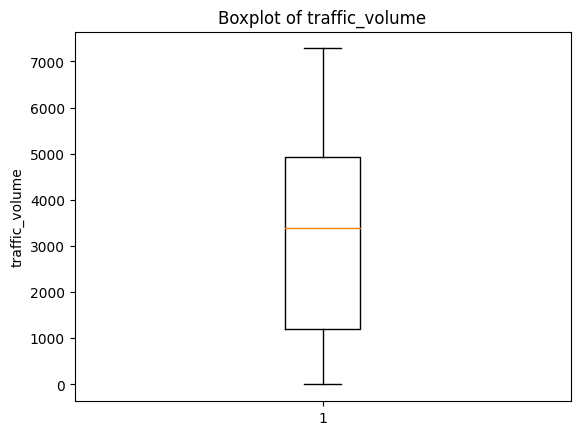

In [1599]:
# Boxplot
plt.boxplot(traffic_df['traffic_volume'])

# Add labels
plt.title('Boxplot of traffic_volume')
plt.ylabel('traffic_volume')

plt.show()

In [1600]:
# Stats about each numeric feature
print(traffic_df['traffic_volume'].describe())

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64


No apparent outliers

### temp

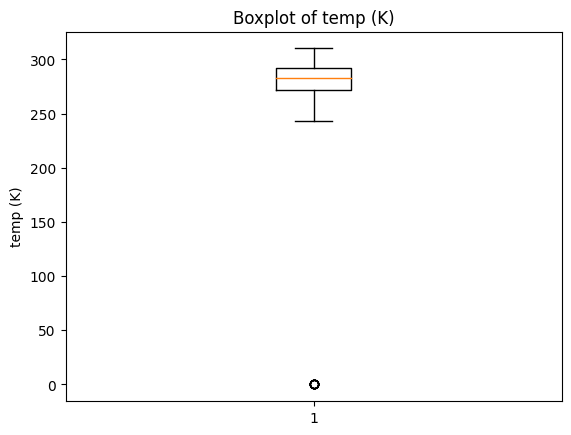

In [1601]:
# Boxplot
plt.boxplot(traffic_df['temp'])

# Add labels
plt.title('Boxplot of temp (K)')
plt.ylabel('temp (K)')

plt.show()

In [1602]:
# Stats about each numeric feature
print(traffic_df['temp'].describe())

count    48204.000000
mean       281.205870
std         13.338232
min          0.000000
25%        272.160000
50%        282.450000
75%        291.806000
max        310.070000
Name: temp, dtype: float64


Remove outlier at 0 (most likely false entry/mistake)

In [1603]:
# Remove outliers
traffic_df=traffic_df[np.absolute(stats.zscore(traffic_df['temp']))<3]

# Reset index
traffic_df=traffic_df.reset_index()

Recheck data

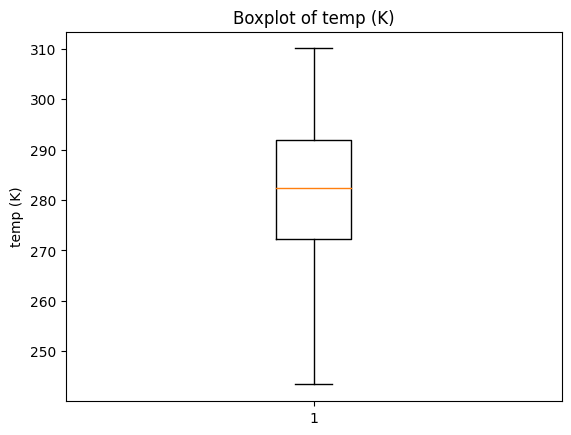

In [1604]:
# Boxplot
plt.boxplot(traffic_df['temp'])

# Add labels
plt.title('Boxplot of temp (K)')
plt.ylabel('temp (K)')

plt.show()

In [1605]:
# Stats about each numeric feature
print(traffic_df['temp'].describe())

count    48194.000000
mean       281.264219
std         12.709587
min        243.390000
25%        272.182500
50%        282.460000
75%        291.810000
max        310.070000
Name: temp, dtype: float64


No apparent outliers

### clouds_all

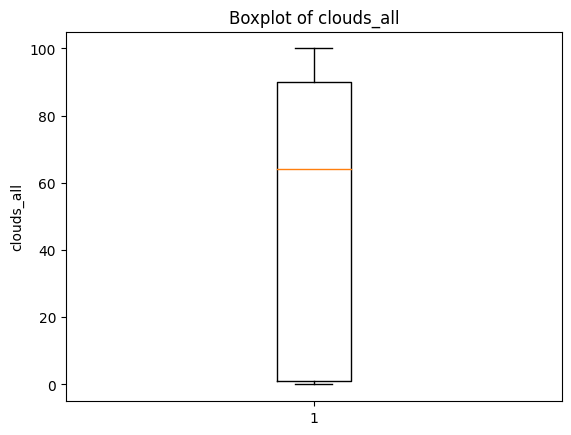

In [1606]:
# Boxplot
plt.boxplot(traffic_df['clouds_all'])

# Add labels
plt.title('Boxplot of clouds_all')
plt.ylabel('clouds_all')

plt.show()

In [1607]:
# Stats about each numeric feature
print(traffic_df['clouds_all'].describe())

count    48194.000000
mean        49.372474
std         39.013317
min          0.000000
25%          1.000000
50%         64.000000
75%         90.000000
max        100.000000
Name: clouds_all, dtype: float64


No apparent outliers

### rain_1h

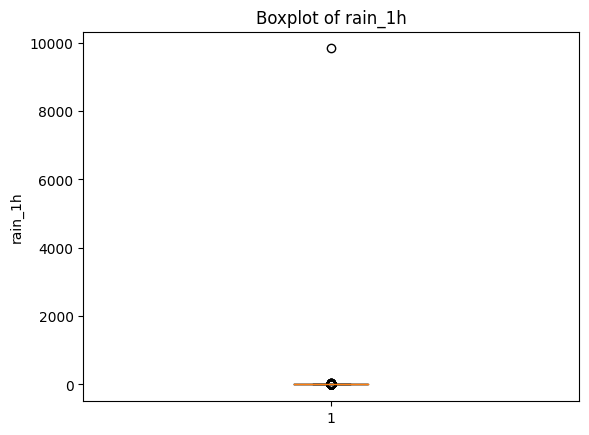

In [1608]:
# Boxplot
plt.boxplot(traffic_df['rain_1h'])

# Add labels
plt.title('Boxplot of rain_1h')
plt.ylabel('rain_1h')

plt.show()

In [1609]:
# Stats about each numeric feature
print(traffic_df['rain_1h'].describe())

count    48194.000000
mean         0.334333
std         44.793779
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       9831.300000
Name: rain_1h, dtype: float64


Some apparent outlier

In [1610]:
# Remove outliers
traffic_df=traffic_df[np.absolute(stats.zscore(traffic_df['rain_1h']))<.9]

# Reset index
traffic_df=traffic_df.reset_index()

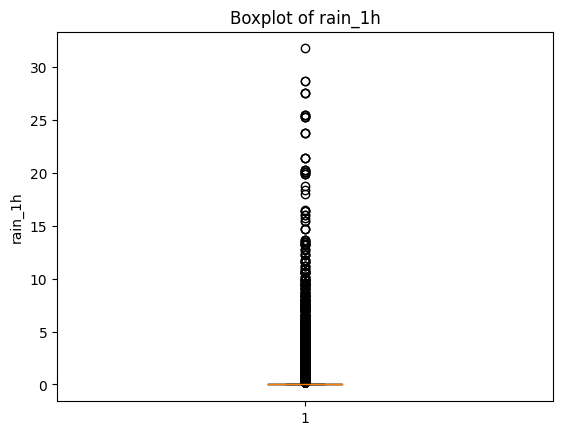

In [1611]:
# Boxplot
plt.boxplot(traffic_df['rain_1h'])

# Add labels
plt.title('Boxplot of rain_1h')
plt.ylabel('rain_1h')

plt.show()

In [1612]:
# Stats about each numeric feature
print(traffic_df['rain_1h'].describe())

count    48191.000000
mean         0.128270
std          0.949912
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         31.750000
Name: rain_1h, dtype: float64


Data has no apparent harmful or misleading outliers; deal with zero-inflation later

### snow_1h

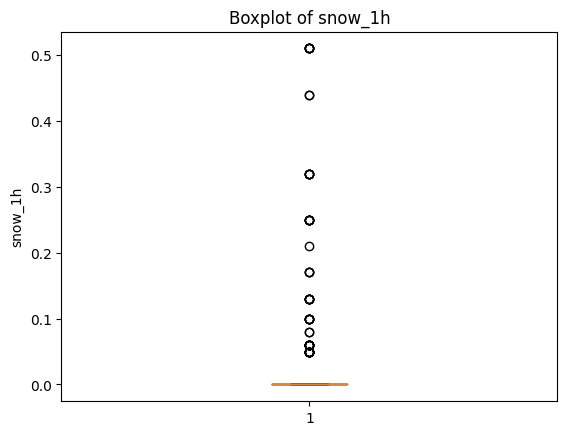

In [1613]:
# Boxplot
plt.boxplot(traffic_df['snow_1h'])

# Add labels
plt.title('Boxplot of snow_1h')
plt.ylabel('snow_1h')

plt.show()

In [1614]:
# Stats about each numeric feature
print(traffic_df['snow_1h'].describe())

count    48191.000000
mean         0.000222
std          0.008169
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.510000
Name: snow_1h, dtype: float64


Data has no apparent harmful or misleading outliers; deal with zero-inflation later

## Minimize Skew

Criteria for Pandas Skew Function

* If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
* If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed
* If the skewness is less than -1 or greater than 1, the data are highly skewed

### traffic_volume

In [1615]:
# Stats about each numeric feature
print(traffic_df['traffic_volume'].describe())

count    48191.000000
mean      3260.203150
std       1986.737523
min          0.000000
25%       1194.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64


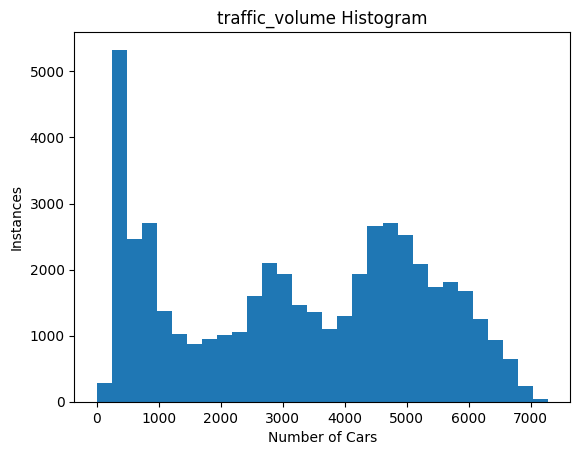

<Figure size 1000x600 with 0 Axes>

In [1616]:
# Histogram
plt.hist(traffic_df['traffic_volume'], bins=30)

# Labels
plt.xlabel('Number of Cars')
plt.ylabel('Instances')
plt.title('traffic_volume Histogram')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

In [1617]:
# Testing skew
print(pd.DataFrame(traffic_df['traffic_volume']).skew(axis=0, numeric_only='True'))

traffic_volume   -0.089602
dtype: float64


Data has no significant skew

### temp

In [1618]:
# Stats about each numeric feature
print(traffic_df['temp'].describe())

count    48191.000000
mean       281.263322
std         12.709405
min        243.390000
25%        272.180000
50%        282.460000
75%        291.808000
max        310.070000
Name: temp, dtype: float64


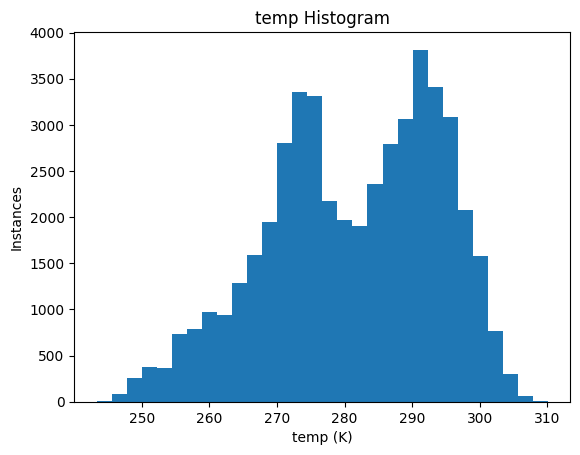

<Figure size 1000x600 with 0 Axes>

In [1619]:
# Histogram
plt.hist(traffic_df['temp'], bins=30)

# Labels
plt.xlabel('temp (K)')
plt.ylabel('Instances')
plt.title('temp Histogram')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

There appears to be left-skew in the histogram, I applied exp, cube, and square transformations. Cube transformation performed best.

In [1620]:
# Cube Transformation
traffic_df['temp']=np.power(traffic_df['temp'], 3)

In [1621]:
# Stats about each numeric feature
print(traffic_df['temp'].describe())

count    4.819100e+04
mean     2.238602e+07
std      2.975135e+06
min      1.441811e+07
25%      2.016363e+07
50%      2.253569e+07
75%      2.484801e+07
max      2.981119e+07
Name: temp, dtype: float64


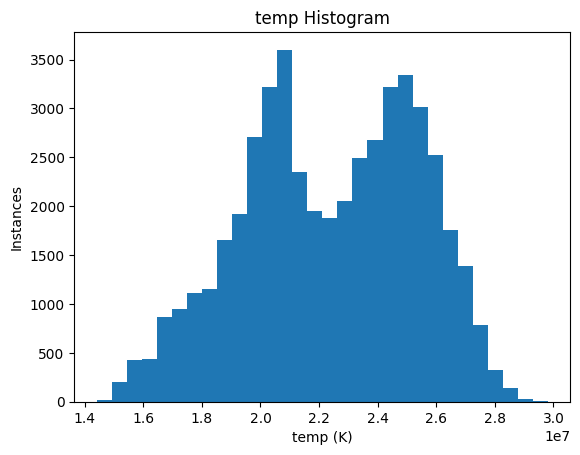

<Figure size 1000x600 with 0 Axes>

In [1622]:
# Histogram
plt.hist(traffic_df['temp'], bins=30)

# Labels
plt.xlabel('temp (K)')
plt.ylabel('Instances')
plt.title('temp Histogram')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

In [1623]:
# Testing skew
print(traffic_df['temp'].skew(axis=0, numeric_only='True'))

-0.20316910175989186


### coulds_all

In [1624]:
# Stats about each numeric feature
print(traffic_df['clouds_all'].describe())

count    48191.000000
mean        49.371003
std         39.014076
min          0.000000
25%          1.000000
50%         64.000000
75%         90.000000
max        100.000000
Name: clouds_all, dtype: float64


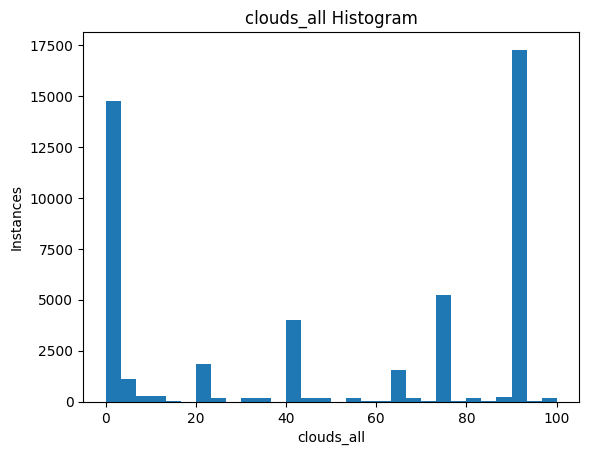

<Figure size 1000x600 with 0 Axes>

In [1625]:
# Histogram
plt.hist(traffic_df['clouds_all'], bins=30)

# Labels
plt.xlabel('clouds_all')
plt.ylabel('Instances')
plt.title('clouds_all Histogram')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

In [1626]:
# Testing skew
print(pd.DataFrame(traffic_df['clouds_all']).skew(axis=0, numeric_only='True'))

clouds_all   -0.197604
dtype: float64


No significant skew

I figure that the way I handle both rain_1h and snow_1h will be the same. I have to deal with semicontinuous variables with true zeros. This rules out tobit regression and data transformations. After a long time researching and contemplating different approaches, I have decided to compare my models on two different datasets.

Convert the data from nominal to ordinal by discretizing the data

I will then attempt to reduce the skew slightly by applying a transformation

I could have done a two-part model and separated the data sets. I am still learning how to do that, so this will have to suffice for now.

### rain_1h

In [1627]:
# Stats about each numeric feature
print(traffic_df['rain_1h'].describe())

count    48191.000000
mean         0.128270
std          0.949912
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         31.750000
Name: rain_1h, dtype: float64


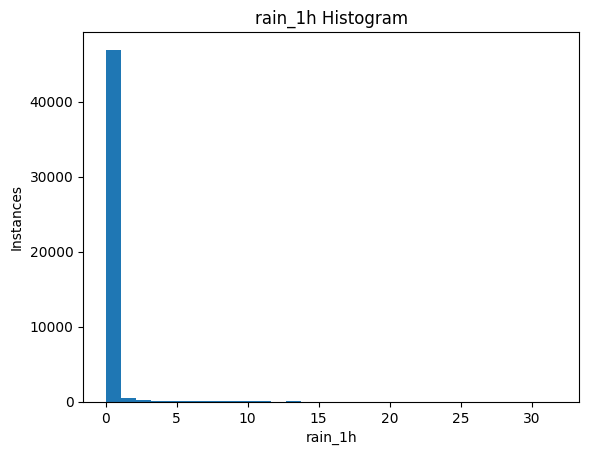

<Figure size 1000x600 with 0 Axes>

In [1628]:
# Histogram
plt.hist(traffic_df['rain_1h'], bins=30)

# Labels
plt.xlabel('rain_1h')
plt.ylabel('Instances')
plt.title('rain_1h Histogram')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

In [1629]:
# Testing skew
print(pd.DataFrame(traffic_df['rain_1h']).skew(axis=0, numeric_only='True'))

rain_1h    15.096753
dtype: float64


Significant right skew due to zero-inflation

In [1630]:
# From outside research about rain- 0-->None(0), 0<Light(1)<=2.5, 2.5<Medium(2)<=8, 8<Heavy(3)
traffic_df['rain_1h']=traffic_df['rain_1h'].apply(lambda x: 0 if x==0 else 1 if x<=2.5 else 2 if x<=8 else 3)

In [1631]:
# Tranforming rain_1h to Minimize Right Skew
traffic_df['rain_1h']=traffic_df['rain_1h'].apply(lambda x: x+1)
traffic_df['rain_1h']=np.log(traffic_df['rain_1h'])

In [1632]:
# Stats about each numeric feature
print(traffic_df['rain_1h'].describe())

count    48191.000000
mean         0.056090
std          0.207858
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.386294
Name: rain_1h, dtype: float64


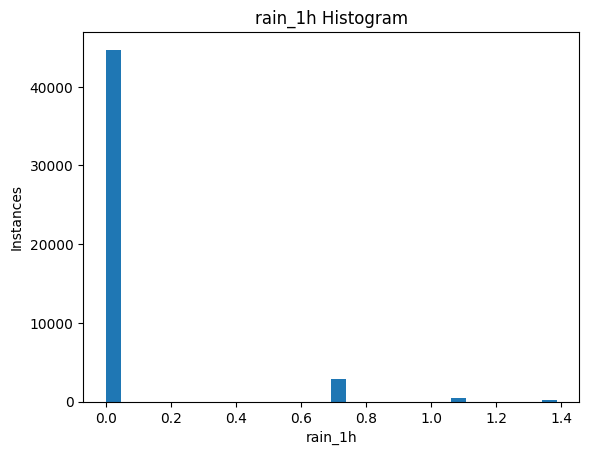

<Figure size 1000x600 with 0 Axes>

In [1633]:
# Histogram
plt.hist(traffic_df['rain_1h'], bins=30)

# Labels
plt.xlabel('rain_1h')
plt.ylabel('Instances')
plt.title('rain_1h Histogram')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

In [1634]:
# Testing skew
print(pd.DataFrame(traffic_df['rain_1h']).skew(axis=0, numeric_only='True'))

rain_1h    3.753251
dtype: float64


Improved

### snow_1h

In [1635]:
# Stats about each numeric feature
print(traffic_df['snow_1h'].describe())

count    48191.000000
mean         0.000222
std          0.008169
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.510000
Name: snow_1h, dtype: float64


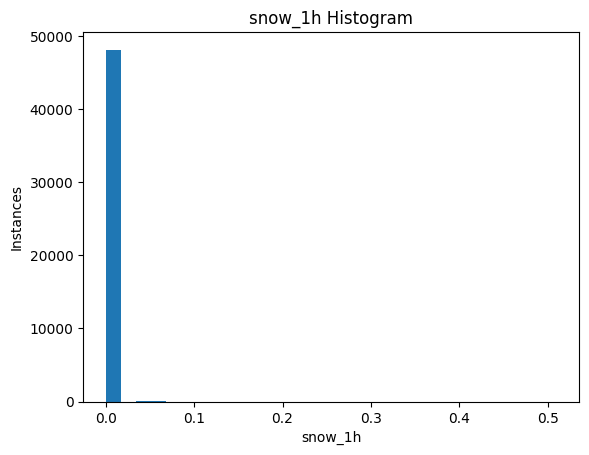

<Figure size 1000x600 with 0 Axes>

In [1636]:
# Histogram
plt.hist(traffic_df['snow_1h'], bins=30)

# Labels
plt.xlabel('snow_1h')
plt.ylabel('Instances')
plt.title('snow_1h Histogram')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

In [1637]:
# Testing skew
print(pd.DataFrame(traffic_df['snow_1h']).skew(axis=0, numeric_only='True'))

snow_1h    48.360955
dtype: float64


Significant right skew due to zero-inflation

In [1638]:
# From outside research about snow
snow_1h=traffic_df['snow_1h']
traffic_df['snow_1h']=traffic_df['snow_1h'].apply(lambda x: 0 if x==0 else 1 if x<=.2 else 2)

In [1639]:
# Tranforming to Minimize Right Skew
traffic_df['snow_1h']=traffic_df['snow_1h'].apply(lambda x: x+1)
traffic_df['snow_1h']=np.log(traffic_df['snow_1h'])

In [1640]:
# Stats about each numeric feature
print(traffic_df['snow_1h'].describe())

count    48191.000000
mean         0.001074
std          0.030471
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.098612
Name: snow_1h, dtype: float64


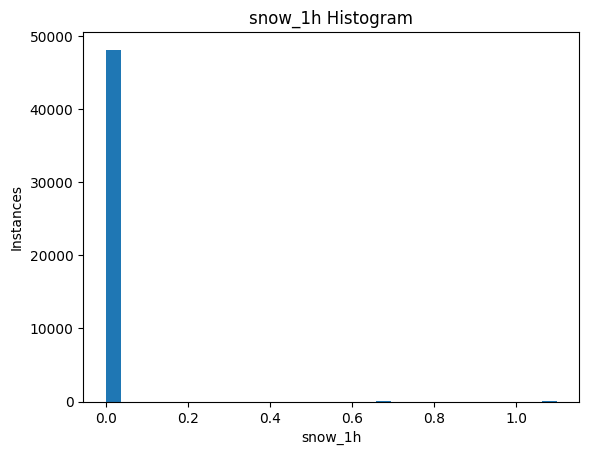

<Figure size 1000x600 with 0 Axes>

In [1641]:
# Histogram
plt.hist(traffic_df['snow_1h'], bins=30)

# Labels
plt.xlabel('snow_1h')
plt.ylabel('Instances')
plt.title('snow_1h Histogram')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

In [1642]:
# Testing skew
print(pd.DataFrame(traffic_df['snow_1h']).skew(axis=0, numeric_only='True'))

snow_1h    29.850672
dtype: float64


Improved

#### Normalize Features

To make them conform to the same scale and improve the performance of certain models

No need to recheck desired aspects of features as they are all preserved when the features are normalized

In [1644]:
myColumns=['traffic_volume', 'temp', 'clouds_all', 'rain_1h', 'snow_1h']
for column in myColumns:
  # Normalizing
  traffic_df[column]=(traffic_df[column]-traffic_df[column].min())/(traffic_df[column].max()-traffic_df[column].min())

# Categorical Features